In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn. pipeline import Pipeline

from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp
from jcopml.pipeline import cat_pipe,num_pipe
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_residual


In [11]:
df=pd.read_csv('data/taxi_fare.csv',parse_dates=['pickup_datetime'])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


,missing_value,%
fare_amount,0,0.00
pickup_datetime,0,0.00
pickup_longitude,0,0.00
pickup_latitude,0,0.00
dropoff_longitude,0,0.00
dropoff_latitude,0,0.00
passenger_count,1,0.01


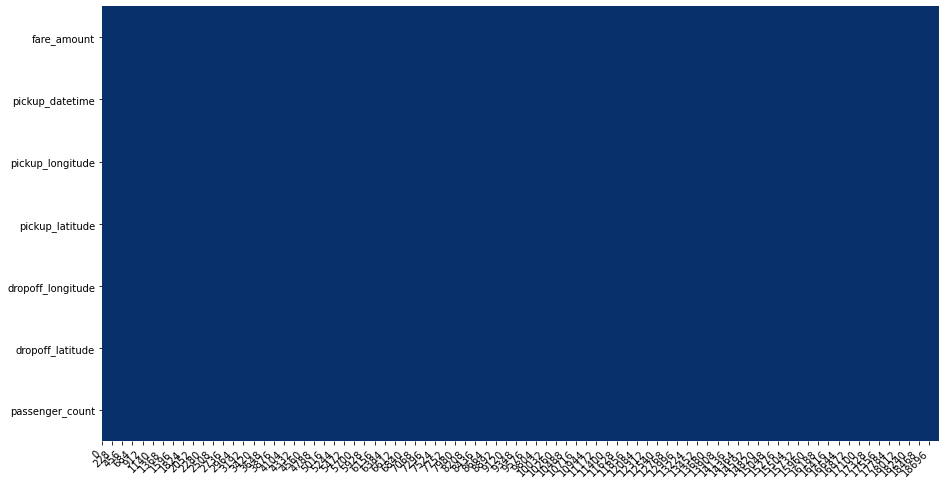

In [12]:
plot_missing_value(df,return_df=True)

In [13]:
df.dropna(inplace= True)

,missing_value,%
fare_amount,0,0.0
pickup_datetime,0,0.0
pickup_longitude,0,0.0
pickup_latitude,0,0.0
dropoff_longitude,0,0.0
dropoff_latitude,0,0.0
passenger_count,0,0.0


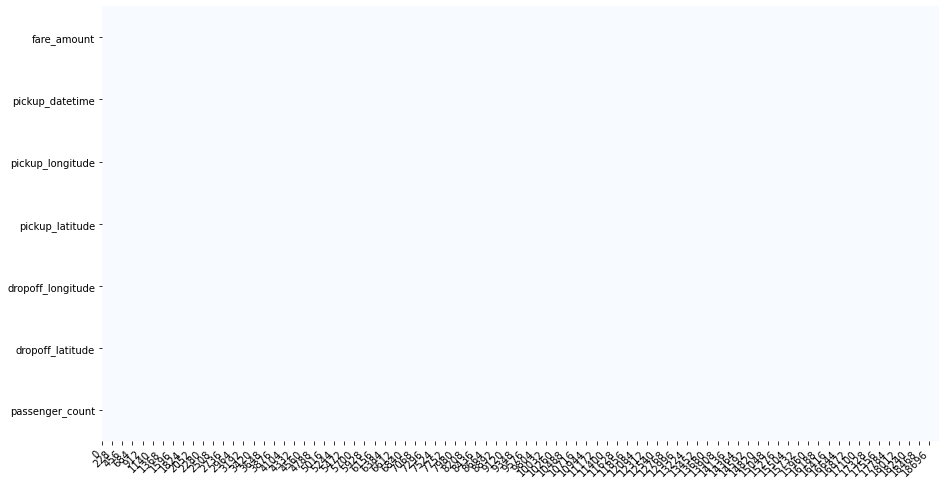

In [14]:
plot_missing_value(df,return_df=True)

lalu parse kolom datetime

In [15]:
pickup_dt=df.pickup_datetime.dt

In [16]:
df['year']= pickup_dt.year
df['month']= pickup_dt.month
df['day']= pickup_dt.day_of_week
df['hour']= pickup_dt.hour

df.drop(columns='pickup_datetime',inplace=True)

In [17]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


jika ada data yang menggunakan garis lintang dan garis bujur lebih baik kita ubah menjadi jarak, dengan ide pembobotan seperti knn (manhattan, eucllidian, cebicev dll). jadi kolom data itu kita msukkan ke rumus tergantung pakai distance apa

In [18]:
df['distance']=np.abs(df.pickup_longitude-df.dropoff_longitude)+np.abs(df.pickup_latitude-df.dropoff_latitude)
df.drop(columns=['pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude'],inplace=True)
df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


dataset splitting

In [19]:
X = df.drop(columns='fare_amount')
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

preprocessing

In [22]:
X_train.head()

,passenger_count,year,month,day,hour,distance
7539,1.0,2011,6,1,22,0.000000
578,3.0,2010,3,3,10,0.009293
8056,5.0,2010,4,0,8,0.048951
11761,1.0,2014,11,0,22,0.027145
15531,1.0,2012,12,5,13,0.010498


In [20]:
X_train.columns

Index(['passenger_count', 'year', 'month', 'day', 'hour', 'distance'], dtype='object')

In [23]:
from sklearn.linear_model import ElasticNet

In [25]:
rsp.enet_params

{'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [26]:
preprocessor= ColumnTransformer([
    ('numeric', num_pipe(poly=2,transform='yeo-johnson'),['passenger_count','distance','year']),
    ('categoric', cat_pipe(),['month','day','hour'])
])

pipiline= Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model= RandomizedSearchCV(pipiline, rsp.enet_params, cv= 3,n_iter=100, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_,model.score(X_test,y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.00018131185116391084, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.9965216519730309}
0.7113552640691976 0.7103952636174881 0.7347994900734349


In [27]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [30]:
preprocessor= ColumnTransformer([
    ('numeric', num_pipe(poly=2,transform='yeo-johnson'),['passenger_count','distance','year']),
    ('categoric', cat_pipe(encoder='onehot'),['month','day','hour'])
])

pipiline= Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])

model= RandomizedSearchCV(pipiline, rsp.enet_poly_params, cv= 3,n_iter=100, n_jobs=-1, verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_,model.score(X_test,y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__alpha': 0.0002342697282971795, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.8248717445601883, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7195027131255749 0.7160011206595879 0.7466570344896424


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166379.38328775382, tolerance: 140.34017623508709
  model = cd_fast.enet_coordinate_descent(


jadi terlihat bahwa walupun pakai poly yang lumayan besar namun karna menggunakan regularization bisa untuk punish model gak terlalu likak likuk parah

feature importance

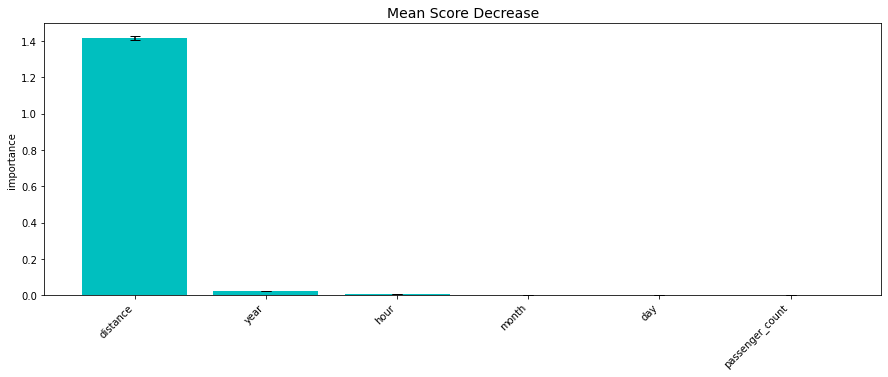

In [31]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

sanse distance ngaruh ke fare, tapi kalau prediksi harga taxi biasanya perlu adanya time tiba dan time berangkat

evaluation residual plot

C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Rahmat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


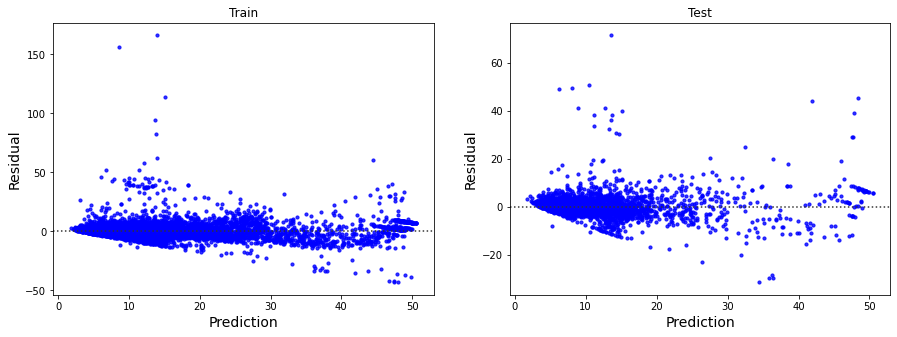

In [32]:
plot_residual(X_train, y_train, X_test, y_test, model)

masih terlihat ada eror, karna bentuk grafik nya belum terlalu simetris, terlihat termasuk heteroskedas city (karna ada kecondongan error di suatu tempat. berarti ada sesuatu di data set kita yang gagal dimodel kan, coba analisis lagi data set

lalu bisa langsung kita tampilin dimana error kita gede, gunakan pandas

plot data asli dengan prediksi lalu hitung error,lalu sorting dataq error itu seperti apa

In [44]:
df_analsis= X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred-y_train)

df_analsis['fare']= y_train
df_analsis ['error'] = error

df_analsis.sort_values('error',ascending=False).head(100)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.113237
1483,1.0,2009,8,4,21,0.000416,165.00,156.362927
6630,1.0,2014,5,4,1,0.000000,128.83,113.731610
14142,1.0,2014,12,4,10,0.045860,108.00,94.354756
12915,1.0,2011,9,2,1,0.000000,96.00,82.242720
10524,1.0,2010,5,1,14,0.000000,75.80,61.823051
12349,1.0,2010,5,5,15,0.434492,104.67,60.216099
1494,1.0,2009,9,1,14,0.000031,70.00,57.830387
2432,1.0,2012,11,4,1,0.003817,58.60,51.890824
2346,1.0,2009,2,5,0,0.000000,63.00,51.591141


### terlihat bahwa ada data yang ngaco di bagian distance (0,0000) tapi memiliki fare yang besar.maka ini yang membuat model kita tidak bisa memodel kan dengan baik

maka proses EDA lebih baik belakangan setelah modeling, karna proses ini butuh effort yang lebih dibandingkan kita memodelkan. tapi langkah awal yang perlu kita lakukan adalah menyeleksi data mana yang gak sesuai dengan apa yang akan kita model kan. dan 4-phase work flow adalah langkah yang benar (think simple, feature importance, poly, fine tuning)

lalu kita perlu bersihin data lagi, atau perlu nambahin data baru agar model kita lebih baik

In [36]:
df[df.fare_amount < 0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
13032,-3.0,4.0,2013,8,4,8,0.001425


lah tambah kerjaan nih masa ada data fare yang negatif.

kita telah menggunakan model simple( linear model),lalu coba pakai algoritma yang power full (ex: xgboost)

dan juga setelah dapat insight dari analisis data sebelum nya dimana ada terdapat data distance yang 0 dan fare yang negatif. maka perlu cleansing data saat kita nyoba model baru

In [46]:
df= df[(df.distance>0) & (df.fare_amount>0)]

In [47]:
df[df.fare_amount < 0]

,fare_amount,passenger_count,year,month,day,hour,distance


clear ya gak ada data yang fare nya negatif lagi

lalu coba pakai algoritma xgboost

In [50]:
from xgboost import XGBRegressor

In [54]:
rsp.xgb_params

{'algo__max_depth': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=100, high=200),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform')}